**Objective**: Build an XGBoost model for predicting heart disease and experiment with hyperparameter tuning to improve its performance.

Dataset: [Heart Disease UCI](https://archive.ics.uci.edu/dataset/45/heart+disease)

# Task 1: Data Loading and Exploration
1. Load the Heart Disease UCI dataset.
2. Explore the dataset to understand its structure and features.
3. Split the data into training and testing sets.

In [104]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
heart_data = pd.read_csv(url, names=column_names, na_values='?')

print(heart_data.head)

X = heart_data.drop('target',axis=1)
y = heart_data['target']

print(X.head)
print(y.head)

<bound method NDFrame.head of       age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca  thal

In [105]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=50)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(242, 13) (61, 13) (242,) (61,)


# Task 2: Data Preprocessing
1. Handle missing values if any.
2. Encode categorical variables using appropriate methods.
3. Standardize or normalize numerical features if necessary.

In [106]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

heart_data.isnull().sum()
numerical_features = heart_data.select_dtypes(include=['float64']).columns
print(numerical_features)

imputer = SimpleImputer(strategy='mean')
X_train[numerical_features] = imputer.fit_transform(X_train[numerical_features])
X_test[numerical_features] = imputer.transform(X_test[numerical_features])


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


In [107]:
categorical_features=['sex','cp','fbs','restecg','exang','slope','ca','thal']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
print(X_train_preprocessed.shape)
X_test_preprocessed = preprocessor.transform(X_test)
print(X_test_preprocessed.shape)

(242, 38)
(61, 38)


# Task 3: Initial XGBoost Model
1. Build an initial XGBoost model using default hyperparameters.
2. Train the model on the training set and evaluate its performance on the testing set.
3. Note down the accuracy and any other relevant metrics.

In [108]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create and train XGBoost model
xgb_model = XGBClassifier(random_state=30, learning_rate=0.001, max_depth=8, n_estimators=100)
xgb_model.fit(X_train_preprocessed, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(X_test_preprocessed)

# Evaluate the accuracy of the model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f'Test accuracy {xgb_accuracy}')

Test accuracy 0.5081967213114754


# Task 4: Hyperparameter Tuning
1. Experiment with hyperparameter tuning to improve model performance.
2. Adjust hyperparameters such as learning_rate, n_estimators, max_depth, etc.
3. Use techniques like cross-validation to find optimal hyperparameters.
4. Train and evaluate the model with the tuned hyperparameters.

In [109]:
from sklearn.model_selection import GridSearchCV, KFold

# Set values to grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2, 3, 4, 5, 6, 8, 10, 12],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70],
    'min_child_weight': [1, 3, 5]
}

# Perform grid search and save best params (may take some seconds)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train)
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 50}


In [110]:
# Evaluate performance of optimized model
best_model = grid_search.best_estimator_

optimized_pred = best_model.predict(X_test_preprocessed)

optimized_accuracy = accuracy_score(y_test, optimized_pred)
print(f'Test accuracy {optimized_accuracy}')

Test accuracy 0.5573770491803278


# Task 5: Feature Importance
1. Explore feature importance using the **feature_importances_** attribute of the trained XGBoost model.
2. Identify the most important features for heart disease prediction.

In [112]:
# Print feature importances
feature_importances = xgb_model.feature_importances_
feature_importance_dict = dict(zip(column_names, feature_importances))
print(feature_importance_dict)

# Print 5 most important features
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]
print("Important features", top_features)

{'age': 0.02484567, 'sex': 0.037874684, 'cp': 0.25232506, 'trestbps': 0.025446009, 'chol': 0.024759496, 'fbs': 0.03909103, 'restecg': 0.051601943, 'thalach': 0.044667408, 'exang': 0.042790025, 'oldpeak': 0.03986751, 'slope': 0.014357012, 'ca': 0.15906507, 'thal': 0.076333255, 'target': 0.0}
Important features [('cp', 0.25232506), ('ca', 0.15906507), ('thal', 0.076333255), ('restecg', 0.051601943), ('thalach', 0.044667408)]


# Task 6: Model Evaluation
1. Compare the performance metrics of the initial model and the tuned model.
2. Visualize the improvement achieved in a clear and concise manner.
3. Discuss the impact of hyperparameter tuning and feature importance on model performance.

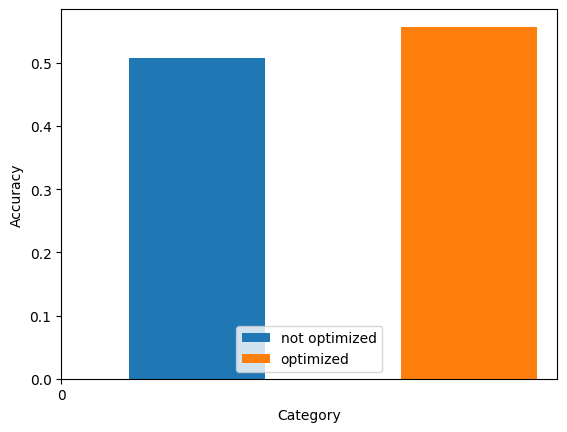

In [113]:
import matplotlib.pyplot as plt

# Create bar chart
plt.bar([0.5], [xgb_accuracy], width=0.5, label='not optimized')
plt.bar([1.5], [optimized_accuracy], width=0.5, label='optimized')

plt.xlabel('Category')
plt.ylabel('Accuracy')
plt.xticks([0])
plt.legend(loc='lower center')

plt.show()

The difference of the accuracy values is only marginal but still it could be improved. This has to be accounted to the fact that the dataset is very small and thus hyperparameter changes to really make a difference.